In [1]:
import numpy as np
from matplotlib import pyplot as plt
import wave

Следующая функция читает из ``wav.``-файла и возвращает два ``numpy`` массива, соответствующих левому и правому каналу:

In [2]:
def read(filename, size=-1):
    fr = wave.open(filename, "rb")
    if size == -1:
        size = fr.getnframes()
    arr = np.array(list(fr.readframes(size)))
    arr = arr.reshape((arr.shape[0] // 4, 4))
    arr = (arr - 128) % 256
    left = arr[:, 0] + arr[:, 1] * 256 - 32768
    right = arr[:, 2] + arr[:, 3] * 256 - 32768
    return left, right

Эта функция, наоборот, пишет два канала в файл:

In [3]:
def write(filename, left, right):
    fw = wave.open(filename, "wb")
    fw.setnchannels(2)
    fw.setsampwidth(2)
    fw.setnframes(left.size)
    fw.setframerate(44100)
    left = (left + 2**15) % 2**16
    right = (right + 2**15) % 2**16
    arr = np.array(((left - 128) % 256, ((left // 256 - 128) % 256),
                   (right - 128) % 256, ((right // 256 - 128) % 256)
                  )).T.flatten()
    fw.writeframes(bytes(list(arr)))
    fw.close()

Проверим, что я нигде не ошибся, и в обоих файлах одинаковые аудиодорожки:

In [4]:
left, right = read('verdi.wav')
write('test.wav', left, right)

In [5]:
fr1 = wave.open('verdi.wav', "rb")
fr2 = wave.open('test.wav', "rb")
print(fr1.readframes(fr1.getnframes()) == fr2.readframes(fr2.getnframes()))

True


Файл ``sample.wav`` --- запись синусоидального сигнала с частотой $1000$ Гц. Удостоверимся в этом:

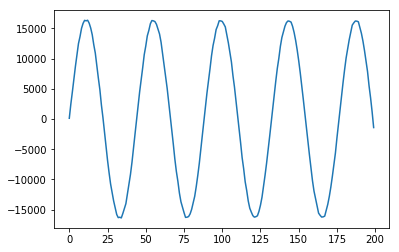

In [6]:
left, right = read('sample.wav')
_ = plt.plot(left[:200])

In [7]:
fft = np.fft.fft(left)
print(44100 / fft.size * np.abs(fft).argmax())

999.9924414781445


Далее попробуем написать какие-нибудь преобразования входного потока данных, основываясь на разложении Фурье:

In [8]:
def drop_weak_freqs(fft, remained):
    fft_abs = np.abs(fft)
    fft_abs.sort()
    fft[np.abs(fft) < fft_abs[-remained]] = 0

In [9]:
def transform(input_file, output_file, func, sample_size=2000, file_size=-1):
    left, right = read(input_file, file_size)
    for i in range(len(left) // sample_size):
        for side in (left, right):
            sample = side[i * sample_size : (i + 1) * sample_size]
            fft = np.fft.fft(sample)
            func(fft)
            ifft = np.fft.ifft(fft)
            ifft = np.real(ifft).round().astype(np.int)
            side[i * sample_size : (i + 1) * sample_size] = ifft
    write(output_file, left, right)

In [ ]:
transform('verdi.wav', 'test-verdi-1.wav', lambda x: drop_weak_freqs(x, 1), sample_size=2000, file_size=10**6)

Преобразование, произведённое строчкой выше, делает из исходной музыки аудиозапись, в которой спокойно на слух различима мелодия, хотя количество информации уменьшилось в 2000 раз!

(Можно было бы написать на базе этого какой-то поиск по мелодиям, если бы я знал, как убирать шум)

In [ ]:
transform('war_and_peace.wav', 'test-speech-20.wav', lambda x: drop_weak_freqs(x, 20), sample_size=2000, file_size=10**7)

Речь довольно хорошо распознаётся, даже если оставить 1% от исходной информации! (см. строку выше) 

Вот по этим графикам можно оценить, насколько хорошо речь приближается таким образом:

In [ ]:
left, right = read('war_and_peace.wav', 10 ** 7)
sample_size = 2000
plt.figure(figsize=(20, 20))
positions = (150, 200, 250, 350, 400, 500)
for cnt, i in enumerate(positions):
    sample = left[i * sample_size : (i + 1) * sample_size]
    fft = np.fft.fft(sample)
    drop_weak_freqs(fft, 20)
    ifft = np.fft.ifft(fft)
    ifft = np.real(ifft).round().astype(np.int)
    plt.subplot(3, 2, cnt + 1)
    plt.plot(ifft)
    plt.plot(sample)

Посмотрим на распределение компонент Фурье, чтобы убедиться в том, что действительно представление в таком базисе весьма разрежено:

In [ ]:
left, right = read('war_and_peace.wav', 10 ** 7)
sample_size = 2000
plt.figure(figsize=(7, 7))
for i in range(100, 120):
    sample = left[i * sample_size : (i + 1) * sample_size]
    fft = np.fft.fft(sample)
    fft_abs = np.abs(fft)
    fft_abs.sort()
    fft_abs = fft_abs[::-1]
    plt.plot(1 / fft_abs)
    plt.ylim(0, 0.001)
    plt.xlim(0, 1000)
    #plt.hist(np.log(fft_abs), bins=20)

Судя по всему, если частоты отсортировать по громкости, то громкость будет убывать обратно пропорционально номеру частоты в списке. Это заставляет верить, что Compressed Sensing будет верно восстанавливать исходную выборку при минимизации $L_1$-нормы.